# Short Breakout Strategy Testing

This notebook tests the **ShortBreakoutStrategy** which implements a contrarian approach to market breakouts.

## Strategy Overview
- **Concept**: Short positions on upward breakouts, betting on price reversion
- **Entry Signal**: Price breaks above recent high by a threshold percentage
- **Exit Signal**: Hold for a specified time period, then close
- **Risk Management**: Limited position size and concurrent position limits

## Strategy Parameters
- **Breakout Threshold**: Minimum percentage above recent high to trigger entry
- **Lookback Period**: Time window to calculate recent high/low
- **Hold Time**: How long to maintain positions before closing
- **Position Size**: Fraction of portfolio allocated per trade

## Test Components
1. **Data Loading & Visualization**
2. **Single Backtest with Default Parameters**
3. **Performance Analysis & Metrics**
4. **Parameter Sensitivity Testing**
5. **Risk Analysis & Trade Visualization**

Let's test this contrarian strategy on Bitcoin data!

In [11]:
# Setup environment and imports
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete!")
print("Modules loaded successfully")

Environment setup complete!
Modules loaded successfully


In [12]:
# Load Bitcoin data for testing
from backtester.data_loader import DataLoader

# Initialize DataLoader
loader = DataLoader(base_path="../data")

# Load Bitcoin data
print("Loading Bitcoin (BTCUSDT) data...")
btc_df = loader.load_symbol("BTCUSDT", file_type="csv")

print("✅ Data loaded successfully!")
print(f"📊 Data shape: {btc_df.shape}")
print(f"📅 Date range: {btc_df['timestamp'].min()} to {btc_df['timestamp'].max()}")

# Convert timestamp to datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Display basic statistics
print(f"\n💰 Price Statistics:")
print(f"   Min price: ${btc_df['low'].min():,.2f}")
print(f"   Max price: ${btc_df['high'].max():,.2f}")
print(f"   Start price: ${btc_df['close'].iloc[0]:,.2f}")
print(f"   End price: ${btc_df['close'].iloc[-1]:,.2f}")
print(f"   Total return (Buy & Hold): {((btc_df['close'].iloc[-1] / btc_df['close'].iloc[0]) - 1) * 100:.2f}%")

# Quick preview
print(f"\n📋 Data Preview:")
display(btc_df.head())

Loading Bitcoin (BTCUSDT) data...
✅ Data loaded successfully!
📊 Data shape: (217441, 7)
📅 Date range: 2022-12-31 22:00:00 to 2023-05-31 22:00:00

💰 Price Statistics:
   Min price: $16,461.80
   Max price: $31,059.00
   Start price: $16,541.00
   End price: $27,090.60
   Total return (Buy & Hold): 63.78%

📋 Data Preview:
✅ Data loaded successfully!
📊 Data shape: (217441, 7)
📅 Date range: 2022-12-31 22:00:00 to 2023-05-31 22:00:00

💰 Price Statistics:
   Min price: $16,461.80
   Max price: $31,059.00
   Start price: $16,541.00
   End price: $27,090.60
   Total return (Buy & Hold): 63.78%

📋 Data Preview:


,timestamp,open,high,low,close,volume,quote_asset_volume
0,2022-12-31 22:00:00,16544.0,16544.3,16540.6,16541.0,257.084,4.252827e+06
1,2022-12-31 22:01:00,16540.9,16541.9,16540.9,16541.5,59.582,9.855661e+05
2,2022-12-31 22:02:00,16541.5,16541.5,16540.5,16541.4,71.693,1.185868e+06
3,2022-12-31 22:03:00,16541.5,16541.5,16541.0,16541.1,28.035,4.637381e+05
4,2022-12-31 22:04:00,16541.1,16542.5,16540.3,16542.4,95.339,1.577066e+06


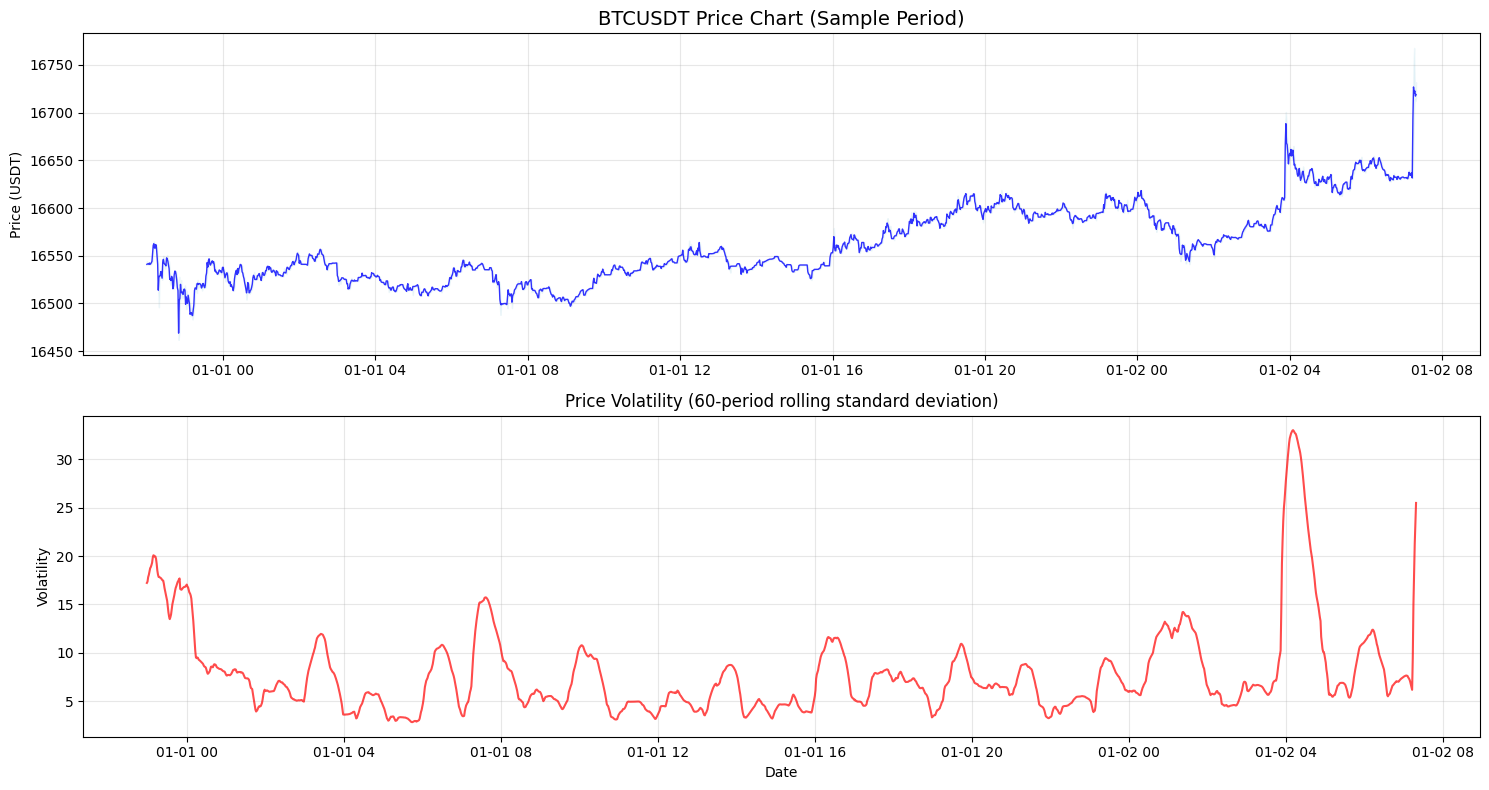

🔍 Breakout Analysis (sample period):
    1.0% threshold:    0 breakouts (0.000% of candles)
    2.0% threshold:    0 breakouts (0.000% of candles)
    3.0% threshold:    0 breakouts (0.000% of candles)
    2.0% threshold:    0 breakouts (0.000% of candles)
    3.0% threshold:    0 breakouts (0.000% of candles)
    5.0% threshold:    0 breakouts (0.000% of candles)

📊 This gives us an idea of how often breakout signals occur with different thresholds
    5.0% threshold:    0 breakouts (0.000% of candles)

📊 This gives us an idea of how often breakout signals occur with different thresholds


In [13]:
# Visualize the data and identify potential breakout scenarios
plt.figure(figsize=(15, 8))

# Plot price data (sample for visualization - first 2000 candles)
sample_data = btc_df.head(2000)
plt.subplot(2, 1, 1)
plt.plot(sample_data['timestamp'], sample_data['close'], linewidth=1, alpha=0.8, color='blue')
plt.fill_between(sample_data['timestamp'], sample_data['low'], sample_data['high'], alpha=0.2, color='lightblue')
plt.title('BTCUSDT Price Chart (Sample Period)', fontsize=14)
plt.ylabel('Price (USDT)')
plt.grid(True, alpha=0.3)

# Calculate and plot volatility
plt.subplot(2, 1, 2)
sample_data['volatility'] = sample_data['close'].rolling(window=60).std()
plt.plot(sample_data['timestamp'], sample_data['volatility'], color='red', alpha=0.7)
plt.title('Price Volatility (60-period rolling standard deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze breakout frequency with different thresholds
print("🔍 Breakout Analysis (sample period):")
lookback_minutes = 30
for threshold in [0.01, 0.02, 0.03, 0.05]:
    breakouts = 0
    for i in range(lookback_minutes, len(sample_data)):
        current_price = sample_data.iloc[i]['close']
        lookback_high = sample_data.iloc[i-lookback_minutes:i]['high'].max()
        if current_price > lookback_high * (1 + threshold):
            breakouts += 1
    
    frequency_pct = (breakouts / len(sample_data)) * 100
    print(f"   {threshold*100:4.1f}% threshold: {breakouts:4d} breakouts ({frequency_pct:.3f}% of candles)")

print(f"\n📊 This gives us an idea of how often breakout signals occur with different thresholds")

In [14]:
# Run backtest with Short Breakout Strategy
from backtester.engine import BacktesterEngine
from backtester.broker import Broker
from backtester.portfolio import Portfolio
from backtester.Strategies.short_breakout_strategy import ShortBreakoutStrategy

print("🚀 Setting up Short Breakout Strategy backtest...\n")

# Initialize portfolio and broker
initial_cash = 100_000  # $100,000 starting capital
portfolio = Portfolio(initial_cash=initial_cash)
broker = Broker(portfolio, fee_rate=0.001)  # 0.1% trading fee

# Create ShortBreakoutStrategy with default parameters
symbols = ["BTCUSDT"]
strategy = ShortBreakoutStrategy(
    symbol="BTCUSDT",
    breakout_threshold=0.02,      # 2% breakout threshold
    lookback_period_minutes=30,   # 30-minute lookback
    hold_time_minutes=60,         # Hold positions for 60 minutes
    position_size=0.1             # Use 10% of portfolio per trade
)

# Initialize backtester engine
engine = BacktesterEngine([strategy], symbols, broker, portfolio)

# Load data into engine
print("📊 Loading data into backtest engine...")
engine.load_data("BTCUSDT", btc_df)
print(f"   Loaded {len(btc_df)} candles for backtesting")

# Initialize strategies
print("🎯 Initializing strategy...")
engine.initialize()

print("\n⚡ Starting backtest execution...")
print("⏱️  This may take a moment for large datasets...")

# Run the backtest
start_time = datetime.now()
engine.run_backtest()
end_time = datetime.now()

execution_time = (end_time - start_time).total_seconds()
print(f"\n✅ Backtest completed in {execution_time:.2f} seconds!")
print(f"📈 Processing rate: {len(btc_df) / execution_time:.0f} candles/second")

🚀 Setting up Short Breakout Strategy backtest...

📊 Loading data into backtest engine...
   Loaded 217441 candles for backtesting
🎯 Initializing strategy...
ShortBreakoutStrategy initialized for BTCUSDT
  Breakout threshold: 2.0%
  Lookback period: 30 minutes
  Hold time: 60 minutes
  Position size: 10.0% of portfolio

⚡ Starting backtest execution...
⏱️  This may take a moment for large datasets...
Breakout detected! SHORT 0.020000 at $23042.50 (breakout: 2.01%)
Fill: SOLD 0.020000 BTCUSDT at $23042.50, fee: $0.4609
Closing short position: BUY 0.020000 at $24352.00 (held for 60.0 min)
Fill: BOUGHT 0.020000 BTCUSDT at $24352.00, fee: $0.4870
Breakout detected! SHORT 0.020000 at $23042.50 (breakout: 2.01%)
Fill: SOLD 0.020000 BTCUSDT at $23042.50, fee: $0.4609
Closing short position: BUY 0.020000 at $24352.00 (held for 60.0 min)
Fill: BOUGHT 0.020000 BTCUSDT at $24352.00, fee: $0.4870
Strategy ended with all positions closed
Final tracked position size: -0.040000

✅ Backtest completed i

In [15]:
# Comprehensive Results Analysis
print("=" * 60)
print("🎯 SHORT BREAKOUT STRATEGY - BACKTEST RESULTS")
print("=" * 60)

# Portfolio Performance
final_equity = portfolio.equity({symbols[0]: btc_df['close'].iloc[-1]})
total_return = (final_equity - initial_cash) / initial_cash * 100
buy_hold_return = (btc_df['close'].iloc[-1] / btc_df['close'].iloc[0] - 1) * 100

print(f"💰 PORTFOLIO PERFORMANCE")
print(f"   Initial Capital:    ${initial_cash:>10,.2f}")
print(f"   Final Equity:       ${final_equity:>10,.2f}")
print(f"   Total Return:       {total_return:>10.2f}%")
print(f"   Absolute Profit:    ${final_equity - initial_cash:>10,.2f}")

print(f"\n📊 BENCHMARK COMPARISON")
print(f"   Buy & Hold Return:  {buy_hold_return:>10.2f}%")
print(f"   Strategy Return:    {total_return:>10.2f}%")
print(f"   Excess Return:      {total_return - buy_hold_return:>10.2f}%")
if buy_hold_return != 0:
    alpha = total_return - buy_hold_return
    print(f"   Alpha:              {alpha:>10.2f}%")

# Position Analysis
print(f"\n🎯 POSITION ANALYSIS")
print(f"   Cash Remaining:     ${portfolio.cash:>10,.2f}")
for symbol, position in portfolio.positions.items():
    if position.size != 0:
        current_price = btc_df['close'].iloc[-1]
        unrealized_pnl = position.size * (current_price - position.avg_price)
        print(f"   {symbol} Position:      {position.size:>10.6f}")
        print(f"   Average Price:      ${position.avg_price:>10.2f}")
        print(f"   Current Price:      ${current_price:>10.2f}")
        print(f"   Unrealized PnL:     ${unrealized_pnl:>10.2f}")
        print(f"   Realized PnL:       ${position.realized_pnl:>10.2f}")

# Trade Statistics
fills = broker.get_fills()
print(f"\n📈 TRADE STATISTICS")
print(f"   Total Trades:       {len(fills):>10d}")

if fills:
    buy_trades = [f for f in fills if f.is_buy]
    sell_trades = [f for f in fills if not f.is_buy]
    
    print(f"   Buy Orders:         {len(buy_trades):>10d}")
    print(f"   Sell Orders:        {len(sell_trades):>10d}")
    
    total_fees = sum(f.fee for f in fills)
    total_volume = sum(f.price * f.size for f in fills)
    avg_trade_size = np.mean([f.price * f.size for f in fills])
    
    print(f"   Total Fees Paid:    ${total_fees:>10.2f}")
    print(f"   Total Volume:       ${total_volume:>10,.2f}")
    print(f"   Average Trade Size: ${avg_trade_size:>10,.2f}")
    
    # Calculate trade frequency
    time_span = (btc_df['timestamp'].iloc[-1] - btc_df['timestamp'].iloc[0]).total_seconds() / 3600  # hours
    trades_per_hour = len(fills) / time_span
    print(f"   Trading Frequency:  {trades_per_hour:>10.2f} trades/hour")

print(f"\n" + "=" * 60)

🎯 SHORT BREAKOUT STRATEGY - BACKTEST RESULTS
💰 PORTFOLIO PERFORMANCE
   Initial Capital:    $100,000.00
   Final Equity:       $100,027.63
   Total Return:             0.03%
   Absolute Profit:    $     27.63

📊 BENCHMARK COMPARISON
   Buy & Hold Return:       63.78%
   Strategy Return:          0.03%
   Excess Return:          -63.75%
   Alpha:                  -63.75%

🎯 POSITION ANALYSIS
   Cash Remaining:     $ 99,485.82
   BTCUSDT Position:        0.020000
   Average Price:      $  23042.50
   Current Price:      $  27090.60
   Unrealized PnL:     $     80.96
   Realized PnL:       $    -26.19

📈 TRADE STATISTICS
   Total Trades:                2
   Buy Orders:                  1
   Sell Orders:                 1
   Total Fees Paid:    $      0.95
   Total Volume:       $    947.89
   Average Trade Size: $    473.95
   Trading Frequency:        0.00 trades/hour



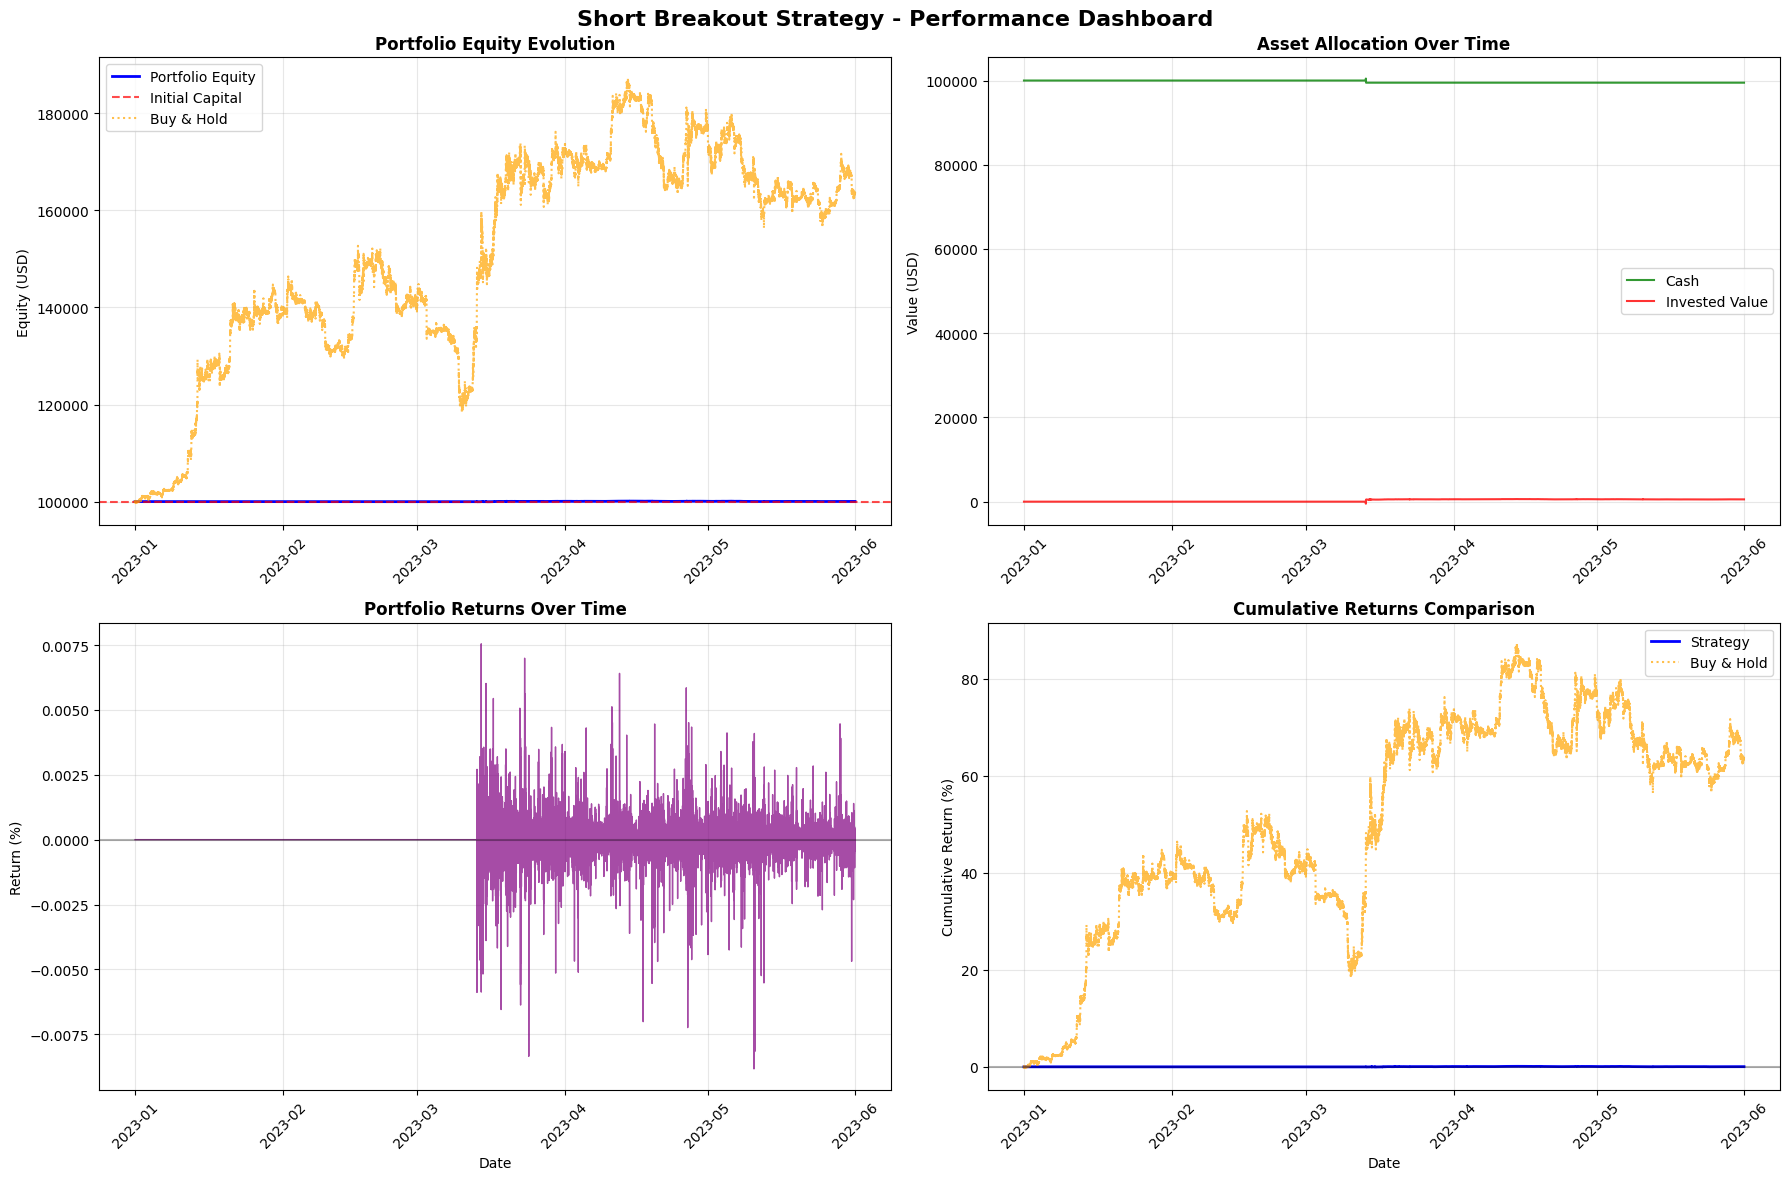


📊 RISK METRICS
----------------------------------------
   Annualized Volatility:      0.20%
   Sharpe Ratio:               0.33
   Maximum Drawdown:          -0.10%
   Win Rate:                  25.69%
   Avg Win/Loss Ratio:         1.01


In [16]:
# Portfolio Performance Visualization
if portfolio.history and len(portfolio.history) > 1:
    # Extract portfolio history data
    timestamps = [snap.timestamp for snap in portfolio.history]
    equity_values = [snap.equity for snap in portfolio.history]
    cash_values = [snap.cash for snap in portfolio.history]
    
    # Convert to pandas for easier handling
    timestamps = pd.to_datetime(timestamps)
    
    # Create comprehensive performance dashboard
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Short Breakout Strategy - Performance Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Equity Over Time
    ax1 = axes[0, 0]
    ax1.plot(timestamps, equity_values, label='Portfolio Equity', linewidth=2, color='blue')
    ax1.axhline(y=initial_cash, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    
    # Add buy & hold comparison
    if len(timestamps) == len(btc_df):
        start_price = btc_df['close'].iloc[0]
        btc_equity = [(btc_df['close'].iloc[i] / start_price) * initial_cash 
                      for i in range(len(equity_values))]
        ax1.plot(timestamps, btc_equity, label='Buy & Hold', alpha=0.7, linestyle=':', color='orange')
    
    ax1.set_title('Portfolio Equity Evolution', fontweight='bold')
    ax1.set_ylabel('Equity (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Cash vs Invested Value
    ax2 = axes[0, 1]
    invested_values = [eq - cash for eq, cash in zip(equity_values, cash_values)]
    ax2.plot(timestamps, cash_values, label='Cash', alpha=0.8, color='green')
    ax2.plot(timestamps, invested_values, label='Invested Value', alpha=0.8, color='red')
    ax2.set_title('Asset Allocation Over Time', fontweight='bold')
    ax2.set_ylabel('Value (USD)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Portfolio Returns
    ax3 = axes[1, 0]
    equity_series = pd.Series(equity_values, index=timestamps)
    returns = equity_series.pct_change().dropna() * 100  # Convert to percentage
    ax3.plot(returns.index, returns.values, alpha=0.7, color='purple', linewidth=1)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Portfolio Returns Over Time', fontweight='bold')
    ax3.set_ylabel('Return (%)')
    ax3.set_xlabel('Date')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Cumulative Returns Comparison
    ax4 = axes[1, 1]
    cumulative_returns = ((equity_series / initial_cash) - 1) * 100
    ax4.plot(timestamps, cumulative_returns, label='Strategy', linewidth=2, color='blue')
    
    # Buy & Hold cumulative return
    if len(timestamps) == len(btc_df):
        btc_cumulative = ((pd.Series(btc_equity) / initial_cash) - 1) * 100
        ax4.plot(timestamps, btc_cumulative, label='Buy & Hold', alpha=0.7, 
                linestyle=':', color='orange')
    
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('Cumulative Returns Comparison', fontweight='bold')
    ax4.set_ylabel('Cumulative Return (%)')
    ax4.set_xlabel('Date')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display risk metrics
    if len(returns) > 1:
        print("\n📊 RISK METRICS")
        print("-" * 40)
        
        # Annualized metrics (assuming 1-minute data)
        annual_factor = np.sqrt(365 * 24 * 60)  # Annualization factor for 1-minute data
        
        volatility = returns.std() * annual_factor
        sharpe_ratio = (returns.mean() / returns.std()) * annual_factor if returns.std() != 0 else 0
        
        # Drawdown analysis
        peak = equity_series.expanding().max()
        drawdown = (equity_series - peak) / peak * 100
        max_drawdown = drawdown.min()
        
        # Additional metrics
        positive_returns = returns[returns > 0]
        negative_returns = returns[returns < 0]
        win_rate = len(positive_returns) / len(returns) * 100 if len(returns) > 0 else 0
        
        print(f"   Annualized Volatility:  {volatility:>8.2f}%")
        print(f"   Sharpe Ratio:           {sharpe_ratio:>8.2f}")
        print(f"   Maximum Drawdown:       {max_drawdown:>8.2f}%")
        print(f"   Win Rate:               {win_rate:>8.2f}%")
        if len(positive_returns) > 0 and len(negative_returns) > 0:
            profit_loss_ratio = positive_returns.mean() / abs(negative_returns.mean())
            print(f"   Avg Win/Loss Ratio:     {profit_loss_ratio:>8.2f}")
        
else:
    print("⚠️  No portfolio history available for visualization.")
    print("   This might happen if no trades were executed or the backtest was very short.")